# 2D Monte Carlo ray-tracing
This notebook contains a simple Monte Carlo ray-tracing solver for radiative transfer in a 2D atmosphere, including a small bit of theoretical background (see e.g. *Mayer, 2009: Radiative transfer in the cloudy atmosphere* for a more extensive overview)

First, we load the required python modules, define four constants and read all atmospheric properties from the netcdf input file

In [33]:
import numpy as np
import netCDF4 as nc
import random as rd
import matplotlib.pyplot as pl
import copy
import matplotlib as mpl
import numba 
import datetime as dt
from math import log
cnt = []#@numba.jit(nopython=True)

ZC=666 # Zero-collision
SC=667 # Scattering
AB=668 # Absorption
BD=669 # Boundary hit
ds = 1e-5 # minimum distance (to shift away from cell boundaries and prevent numerical issues)

nc_file   = nc.Dataset("raytracing_input.nc")

z_size     = nc_file.dimensions["z"].size # vertical domain size
x_size     = nc_file.dimensions["x"].size # horizontal domain size
size = np.array([z_size, x_size])

k_ext_cld = nc_file.variables['k_ext_cld'][:] # extinction coefficient of cloud droplets
k_ext_gas = nc_file.variables['k_ext_gas'][:] # extinction coefficient of cloud droplets
k_sca_cld = nc_file.variables['k_sca_cld'][:] # scattering coefficients of cloud droplets
k_sca_gas = nc_file.variables['k_sca_gas'][:] # scattering coefficients of gas molecules

sza     = nc_file.variables['sza'][:]    # solar zenith angle
g       = nc_file.variables['g'][:]      # asymmetry parameter (assume constant)
albedo  = nc_file.variables['albedo'][:] # surface albedo

# total extinction coefficient
k_ext = k_ext_cld + k_ext_gas

# total scattering coefficient
k_sca = k_sca_cld + k_sca_gas

# k_hat = k_ext+k_null, where k_null is defined such that k_hat is constant in space
# therefore, k_hat is set to the maximum value of k_ext in the domain
k_hat = k_ext.max()

# ratio cloud scattering coefficient over total scattering coefficient
cloud_scat_frac = k_sca_cld / k_sca

# compute cloud mask, if ccf == 0, no cloud is present
cloud_mask = (k_sca_cld != 0)

# randomly return either 1 or -1
@numba.jit(nopython=True)
def rand_sign():
    return (-1+2*(rd.random()>.5))

## Scattering functions
When a photon hits a molecule or cloud droplet, it is either scattered or absorped. If the photon is scattered, we need to sample a random scattering angle from a probability distribution. We define two different scattering functions, depending on whether the photon is scattered by a cloud droplet or a gas molecule.

#### Henyey-Greenstein function
The Henyey-Greenstein phase function is an approximation of the very complex and expensive to calculate Mie scattering and often used for scattering by clouds. It is a probability density function for $\mu$, the cosine of scattering angle $\theta$ ($\mu=\cos\theta$)

$$P_\mathrm{HG}\left(\mu\right)=\frac{1-g^2}{2\left(1+g^2-2g\mu\right)^{3/2}},$$

where $g$ is the asymmetry parameter, which is defined as the intensity-weighted average of $\mu$. Scattering is purely forward if $g=1$, purely backward if $g=-1$ and isotropic if $g=0$, but typically $g$ is around $0.85$. To be able to sample a random $\mu$, integrate $P_\mathrm{HG}\left(\mu\right)$ from $-1$ to $\mu$ and solve for $\mu$:

$$\mu_\mathrm{HG}=\dfrac{1}{2g}\left(1+g^2-\left(\dfrac{g^2-1}{2gr-g-1}\right)^2\right),$$

where $r$ is a random number between 0 and 1

In [2]:
@numba.jit(nopython=True)
def henyey(g=.85): #henyey greenstein scattering   
    r = rd.random()
    a = (1.-g**2)**2
    b = 2.*g*(2*r*g+1.-g)**2
    c = -g/2.-1./(2*g)
    return -1*(a/b)-c

#### Rayleigh function
For scattering by molecules, we use the Rayleigh phase function

$$P_\mathrm{Rayleigh}\left(\mu\right) = \dfrac{3}{8}\left(1+\cos^2\theta\right),$$

and, after integrating from $-1$ to $\mu$ and solving for $\theta$,

$$\mu_\mathrm{Rayleigh} = u-\frac{1}{u},\ u=\left(-q+\sqrt{1+q^2}\right)^{1/3}\ \mathrm{and}\ q=4r-2,$$

where r is a random number between 0 and 1.

In [3]:
@numba.jit(nopython=True)
def rayleigh(): 
    r = rd.random()
    q = -8*r+4
    d = 1+q*q/4
    u = (-q/2+np.sqrt(d))**(1/3.)
    return u-1/u

#### Direction after scattering
To compute the new photon direction after scattering, we first calculate the angle between the current direction of the photon and the positive x-axis and then either add or substract the scattering angle. 

In [4]:
# cur_direction = [direction_z (vertical), direction_x (horizontal)]
@numba.jit(nopython=True)
def new_direction(mu, current_direction):
    angle = np.arctan2(current_direction[0], current_direction[1]) + np.arccos(mu) * (-1+2*(rd.random()>.5))      
    return np.array([np.sin(angle),np.cos(angle)], dtype=np.float32)


## Sampling optical depth

The amount of scattering and absorption in the atmosphere 
The decrease in radiative flux along a path in a non-transparent atmosphere is determined by the Lambert-Beer law, so the radiative flux after a distance $s$ from the top of the atmosphere is

$$I(s)=-I_0\exp{\tau}, \tag{1}$$ 

where $I_0$ is the radiative flux at the top of atmosphere and $\tau$ is the optical depth, which is the integral of the extinction coefficient ($k_\mathrm{ext}$) over distance $s$: 

$$\tau=\int k_\mathrm{ext} ds\tag{2}.$$

The extinction coefficient is the sum of the absorption coefficient $k_\mathrm{abs}$ and the scattering coefficient $k_\mathrm{sca}$. Note that the extinction coefficient is not a constant, but a function of wavelength, temperature, pressure, humidity, cloud thickness and more. 

As given by eq. 1, the fraction of photon surviving after a distance $\tau$ is $e^{-\tau}$, which also means that a random photon has a $e^{-\tau}$ chance of travelling further than a distance $\tau$ before hitting a molecule or cloud droplet. For each initialised photon, we sample a random $\tau$ from a probability distribution, such that after many photons the fraction of photons that will travel further than $\tau$ is $e^{-\tau}$:

$$\tau = -\ln{\left(1-r\right)},\tag{3}$$ 

where $r$ is a random number between 0 and 1

In [5]:
@numba.jit(nopython=True)
def sample_tau():
    return -log(1-rd.random())


## Moving photons
Having sampled a random $\tau$ (eq. 3), we can compute the distance the photon will travel before hitting a molecule by inverting eq. 2. Because $k_\mathrm{ext}$ ($=k_\mathrm{abs} + k_\mathrm{sca}$) is a complicated function of space, we would need to integrate over all grid cells traversed by the photon and thus keep track of all intersected grid cells, which is computationally quite expensive. Instead, we add a so-called null collision coefficient $k_\mathrm{null}$ to each grid cell such that the sum $\hat{k}=k_\mathrm{abs} + k_\mathrm{sca} + k_\mathrm{null}$ is constant in space. Now we can substitute $k_\mathrm{ext}$ for $\hat{k}$ in eq. 2 and invert the equation: $s = \frac{\tau}{\hat{k}}$.

The photons will travel distance $s$, unless it hits a domain boundary first. With position vector $\boldsymbol{p}=\begin{bmatrix} p_z \\ p_x \end{bmatrix}$ and direction vector $\boldsymbol{d}=\begin{bmatrix} d_z \\ d_x \end{bmatrix}$, the new position of the photon is $\boldsymbol{p^{i+1}} = \boldsymbol{p^{i}} + \boldsymbol{d^{i}} \mathrm{min}\left(s, s_\mathrm{max}\right),$ where $s_\mathrm{max}$ is the distance to a domain boundary in the direction of the photon.

If the photon does not hit a domain boundary, it interacts with a molecule or cloud droplet and we draw a random number $r$ to sample whether the photon is scattered ($r\hat{k} \leq k_\mathrm{sca}$), absorbed ($ k_\mathrm{sca} < r\hat{k} < k_\mathrm{ext}$) or whether the interaction is a null-collision ($r\hat{k} \geq k_\mathrm{ext}$).

In [6]:
@numba.jit(nopython=True)
def move_photon(k_ext, k_sca, k_hat, size, position, direction):
    s     = sample_tau()/k_hat # distance based on randomly sampled optical depth (tau)
    s_max = np.min(((size*(direction>0)-position)/direction)) #distance to domain boundary
    if (s+ds) >= s_max: # we hit domain boundary first
        position += direction*s_max
        
        # Slighty shift away from cell boundary
        position += np.sign(direction) * ds
        
        event=BD
    else: 
        position += direction*s
        r = rd.random()
        if r*k_hat >= k_ext[int(position[0]),int(position[1])]:
            event = ZC 
        elif r*k_hat <= k_sca[int(position[0]),int(position[1])]:
            event = SC
        else:
            event = AB

    return event, position, direction

## Interactions
The 'interaction_event' function handles the possible interactions of photons with cloud droplets and gas molecules or the crossing of domain boundaries. The function returns whether the photon is alive (i.e. not absorbed, so we continue tracing the photon) and whether photon still contributes to the direct (non-scattered) radiation. If necessary, the function also updates the direction vector.

#### Scattering
If the photon is scattered, it can be scattered by either a cloud droplet (if present where the photon is scattered) or a gas molecule. The chance of being scattered by a cloud droplet  is equal to $\dfrac{k^\mathrm{cloud}_\mathrm{sca}}{k^\mathrm{tot}_\mathrm{sca}}$ , so we sample a random number $r$ between 0 and 1 and we assume cloud droplet scattering if $r<\dfrac{k^\mathrm{cloud}_\mathrm{sca}}{k_\mathrm{sca}}$ and gas molecule scattering otherwise. Having determined the type of scattering, we use either the Henyey-Greenstein or the Rayleigh function to compute a scattering angle and then compute a new direction. After scattering, we continue tracing the photon.

#### Absorption
Once the photon has been absorbed, we stop tracing it.

#### Null-collision
There is no actual interaction, so we do not have to update the direction and we just continue tracing the photon.

#### Boundary hit
If the photon crosses the horizontal domain boundaries we apply cyclic boundary conditions to ensure the photon stays in the domain and continue ray tracing. If the photos crosses the top boundary, it leaves the domain and we stop ray tracing. If the photon crosses the bottom boundary, it is either absorbed by the surface or reflected, as determined by the albedo. If a random number $r$ is smaller than the albedo, the photon is reflected, otherwise it is absorbed. 

In [7]:
@numba.jit(nopython=True)
def interaction_event(event_type, cloud_scat_frac, g, size, position, direction, is_direct, albedo):
    # Photon is scattered
    if event_type == SC:
        is_direct = False # photon is scattered, so it is no longer direct
        if rd.random()<cloud_scat_frac[int(position[0]),int(position[1])]: #always false if no cloud is present
            direction[:] = new_direction(henyey(g), direction) # cloud scattering
        else:
            direction[:] = new_direction(rayleigh(), direction) # gas scattering
        return True, is_direct
    
    # Photon is absorbed
    elif event_type == AB:
        return False, is_direct
    
    # Null-collision
    elif event_type == ZC:
        return True, is_direct          
    
    # Photon hits boundary
    elif event_type == BD:
        # Photon crossed left or right boundary: apply cyclic boundary conditions
        if position[1] > size[1] or position[1] < 0: 
            position[1] %= size[1]       
            return True, is_direct
        # Photon left top of domain
        elif position[0] >= size[0]: 
            return False, is_direct
        
        # Photon interacts with surface
        elif position[0] <= 0: 
            if rd.random() > albedo: # Absorption by surface
                return False, is_direct 
            
            else: # Surface scattering: lambertian surface
                is_direct = False
                position[0] = ds # Slighly shift photon away from bottom
                mu_sfc  = np.sqrt(rd.random()) # Cosine of surface scattering angle
                direction[:] = np.array([mu_sfc,np.sin(np.arccos(mu_sfc)) * rand_sign()], dtype=np.float32)
                return True, is_direct 
            
        else: 
          print("This it not supposed to happen!")
          return True, is_direct

## Tracing a photon
A photon is initialised at the top of the domain at a random location along the horizontal axis and its initial direction is based on the solar zenith angle. Then, the photon is traced until it is absorbed or it leaves the top of the domain. 

In [68]:
# Initialisation function
@numba.jit(nopython=True)
def initialise_photon(size, sza):
    position  = np.array([size[0]-1e-5, rd.random()*size[1]], dtype=np.float32) 
    direction = np.array([-np.cos(sza), np.sin(sza)], dtype=np.float32)
    return position, direction

@numba.jit(nopython=True)
def trace_photon(k_ext, k_sca, g, cloud_mask, cloud_scat_frac, k_hat, size, sza, albedo):
    alive = True
    is_direct = True
    position, direction = initialise_photon(size, sza)
    it = 0
    while alive: #trace photon until it is absorbed or leaves the top of the domain
        event_type, position, direction = move_photon(k_ext, k_sca, k_hat, size, position, direction)
        alive, is_direct = interaction_event(event_type, cloud_scat_frac, g, size, \
                                     position, direction, is_direct, albedo)
        it += 1
        if it>5000: # quit to prevent extremely long loops. >5000x iterations happens like 1 in 1 million times
            alive = False
    # return whether the photon still counts as direct radiation and the final position of the photon
    return is_direct, position    

## Main 
We choose the number of photons to shoot, count how many photons are absorbed by the surface and where, and plot the result

In [69]:
n_photon = 1e5
cnt = []

sfc_direct = np.zeros(size[1])
sfc_diffuse = np.zeros(size[1])
start = dt.datetime.now()
for i in range(int(n_photon)):
    is_direct, position = trace_photon(k_ext, k_sca, g, cloud_mask, cloud_scat_frac, k_hat, size, sza, albedo)
    if position[0] <= 0:
        if is_direct:
            sfc_direct[int(position[1])] += 1
        else:
            sfc_diffuse[int(position[1])] += 1
end = dt.datetime.now()
print("Traced %i photons in %6.2f seconds"%(n_photon,(end-start).seconds+(end-start).microseconds*1e-6))

direct  = np.array(sfc_direct)/n_photon
diffuse = np.array(sfc_diffuse)/n_photon


Traced 100000 photons in   3.28 seconds


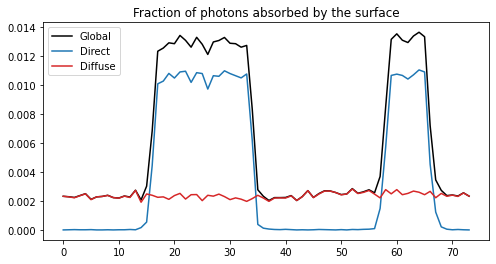

In [15]:
# Plotting results (1): Horizontal distribution of the fraction of photons absorbed at the surface,
# for the diffuse (scattered) and direct (non-scattered) "irradiance" and their sum (global "irradiance") (diffuse)
pl.figure(figsize=(8,4))
pl.plot(direct + diffuse, c="k",  label="Global")
pl.plot(direct, c="C0", label="Direct")
pl.plot(diffuse, c="C3", label="Diffuse")
pl.title("Fraction of photons absorbed by the surface")
pl.legend(loc=2)
pl.show()



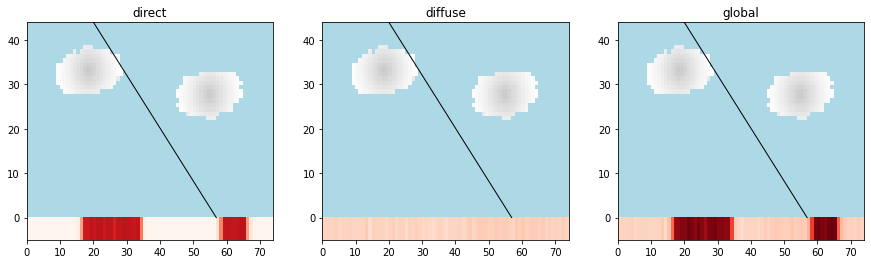

In [16]:
# Plotting results (2): 2D visualisation, which includes position and thickness of clouds
# The fraction of absorbed photon at the surface is shown with the red colors on the bottom of each subplot
# the black lines shows the direction of the solar zenith angle
vmax_value = (direct + diffuse).max()
cmap = copy.copy(mpl.cm.get_cmap("Greys_r"))

pl.figure(figsize=(15,4))
pl.subplot(131)
cb=pl.pcolormesh(k_ext_cld, cmap=cmap, vmin=1e-5)
cb.cmap.set_under('lightblue')
pl.pcolormesh(np.arange(x_size+1), np.arange(-5, 1, 1),
              np.ones((5, x_size))*direct, cmap='Reds', vmin=0, vmax=vmax_value)
pl.plot([20, 20 + np.tan(sza) * z_size], [z_size, 0], c='k',lw=1)
pl.ylim(-5, z_size)
pl.title('direct')

pl.subplot(132)
cb=pl.pcolormesh(k_ext_cld, cmap=cmap, vmin=1e-5)
cb.cmap.set_under('lightblue')
pl.pcolormesh(np.arange(x_size+1), np.arange(-5, 1, 1),
              np.ones((5, x_size))*diffuse, cmap='Reds', vmin=0, vmax=vmax_value)
pl.plot([20, 20 + np.tan(sza) * z_size], [z_size, 0], c='k',lw=1)
pl.ylim(-5, z_size)
pl.title('diffuse')

pl.subplot(133)
cb=pl.pcolormesh(k_ext_cld, cmap=cmap, vmin=1e-5)
cb.cmap.set_under('lightblue')
pl.pcolormesh(np.arange(x_size+1), np.arange(-5, 1, 1),
              np.ones((5, x_size))*(direct+diffuse), cmap='Reds', vmin=0, vmax=vmax_value)
pl.plot([20, 20 + np.tan(sza) * z_size], [z_size, 0], c='k',lw=1)
pl.ylim(-5, z_size)
pl.title('global')
pl.show()